In [13]:
import os
from sklearn.decomposition import FastICA, PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from osgeo import gdal
import rasterio
from scipy.interpolate import interp2d
from numpy.ma import masked_array
import glob
import h5py
from datetime import datetime, timedelta
import geopandas as gpd
from scipy.stats import linregress
from matplotlib.dates import date2num, num2date
import pandas as pd
from shapely.geometry import Point, Polygon
from rasterio.transform import from_origin
import netCDF4 as nc
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning

# this is Andrew Watson's library of functions, see https://github.com/Active-Tectonics-Leeds/interseismic_practical
import sys
import interseis_lib as lib


In [14]:
# load files for frames

frames = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/ica_high_res_frames.txt"
cumh5_dir = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/cumh5"
mask_dir = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/mask"
EQA_dir = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/EQA.dem_par"
subs_poly_path = '/home/users/eejap002/ica_scripts/polygons/vU_merge_161023_noBabRas_WGS84_fillednosmooth_wmean_rad2_dist18_ltemin10_polygonised_dissolved.shp'

with open(frames, "r") as file:
    frames_list = file.read().splitlines()

frames_data = []

for frame in frames_list: 
    EQA_par_pattern = os.path.join(EQA_dir,f"{frame}_GEOCml*GACOSmask_EQA.dem_par")
    EQA_par_file = glob.glob(EQA_par_pattern)
    cumh5_pattern = os.path.join(cumh5_dir,f"{frame}_GEOCml*GACOSmask_cum.h5")
    cumh5_file = glob.glob(cumh5_pattern)
    mask_pattern = os.path.join(mask_dir,f"{frame}_GEOCml*GACOSmask_coh_03_mask.geo.tif")
    mask_file = glob.glob(mask_pattern)

    with h5py.File(cumh5_file[0], 'r') as file:
        imdates = file['imdates']
        imdates = imdates[:] 
        vel = file['vel']
        vel = vel[:]
        cum = file['cum']
        cum = cum[:]

    dates=[]
    for date_value in imdates:
        date_string = str(date_value)  # Convert int32 to string
        year = int(date_string[:4])
        month = int(date_string[4:6])
        day = int(date_string[6:])
        real_date = datetime(year, month, day)
        dates.append(real_date)    

    width = int(lib.get_par(EQA_par_file[0],'width'))
    length = int(lib.get_par(EQA_par_file[0],'nlines'))
    
    # get corner positions
    corner_lat = float(lib.get_par(EQA_par_file[0], 'corner_lat'))
    corner_lon = float(lib.get_par(EQA_par_file[0], 'corner_lon'))

    # get post spacing (distance between velocity measurements)
    post_lat = float(lib.get_par(EQA_par_file[0],'post_lat'))
    post_lon = float(lib.get_par(EQA_par_file[0],'post_lon'))

    # calculate grid spacings
    lat = corner_lat + post_lat*np.arange(1,length+1) - post_lat/2
    lon = corner_lon + post_lon*np.arange(1,width+1) - post_lon/2

    frames_data.append({
        'frame': frame,
        'EQA_file': EQA_par_file,
        'cumh5_file': cumh5_file,
        'mask_file': mask_file,
        'imdates': imdates,
        'vel': vel,
        'cum': cum,
        'dates': dates,
        'width': width,
        'length': length,
        'corner_lat': corner_lat,
        'corner_lon': corner_lon,
        'post_lat': post_lat,
        'post_lon': post_lon,
        'lat': lat,
        'lon': lon
            })

    # Create GeoDataFrame
    frames_gdf = gpd.GeoDataFrame(frames_data, columns=['frame', 'EQA_file', 'cumh5_file', 'mask_file', 'imdates', 'vel', 'cum', 'dates', 'width', 'length', 'corner_lat', 'corner_lon', 'post_lat', 'post_lon','lat', 'lon'])

(192, 133940)
(187, 89040)
(177, 91460)
(187, 93224)


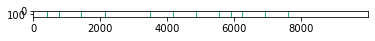

In [15]:
# cum shape is (t, lat, lon)
# we want to make an array of (time, pixels)
# we want to reshape cum (202, 268, 327) into (202,(268*327))

frames_gdf["cum_"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_data = row['cum']

    # Check if 'cum' data is not empty
    if not np.isnan(cum_data).all():
        cum_shape = cum_data.shape
        n_pix = cum_shape[1] * cum_shape[2]

        cum_ = np.reshape(cum_data, (cum_shape[0], n_pix))
        print(cum_.shape)
        frames_gdf.at[index, 'cum_'] = cum_
plt.imshow(cum_[:,40000:50000])

In [16]:
# we have cum of shape 202, 268, 327 and mask tif. We want to mask cum with mask tif 
# i.e. make pixels in cum nan where mask_tif = 0. NaNs are where no data e.g. outside of frame, low coh...

frames_gdf["cum_masked"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_data = row['cum_']
    mask = row['mask_file']

    with rasterio.open(mask[0]) as tif:
    # Read the raster data
        mask_tif = tif.read(1)

        # Reshape the mask to 1D
        mask_1d = mask_tif.flatten()

        # Tile the first row along the rows to match the shape of asc_cum_
        mask_2d = np.tile(mask_1d, (cum_data.shape[0],1))
        print(mask_2d.shape)
        
        # Apply the mask to every element in the 3D array
        cum_masked = cum_data * mask_2d
        
        frames_gdf.at[index, 'cum_masked'] = cum_masked
        print(cum_masked.shape)

(192, 133940)
(192, 133940)
(187, 89040)
(187, 89040)
(177, 91460)
(177, 91460)
(187, 93224)
(187, 93224)


In [17]:
# clip data to subsidence regions
gdf_polygons = gpd.read_file(subs_poly_path)

# keep only subsiding polygon pixels from cum_no_zeros_no_nans
# convert polygons shape into a geopandas dataframe
frames_gdf["cum_polygon_masked_3d"] = ""
frames_gdf["cum_polygon_masked_2d"] = ""

# take cum and non zero or nan indices to reconstruct pixels we want to use in ICA
# then clip these reconstructed pixels using the shp geodataframe
for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_masked = row['cum_masked']
    lon_plot = row['lon']
    lat_plot = row['lat']
    cum = row['cum']

    # Create meshgrid of lon and lat
    lon, lat = np.meshgrid(lon_plot, lat_plot)

    # Flatten lon and lat
    lon_1d = lon.flatten()
    lat_1d = lat.flatten()

    # Create a GeoDataFrame for the flattened lon and lat
    geometry = [Point(lon, lat) for lon, lat in zip(lon_1d, lat_1d)]
    gdf_points = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'])
    gdf_points.crs = "EPSG:4326"
    gdf_points['Latitude'] = lat_1d
    gdf_points['Longitude'] = lon_1d

    # Perform Spatial Join- i.e. clip points to save those within the polygons
    joined = gpd.sjoin(gdf_points, gdf_polygons, predicate='within')

    extracted_coordinates = joined[['Latitude', 'Longitude']]

    extracted_indices = joined.index

    # Create a boolean mask for lon and lat arrays
    mask = np.isin(np.arange(lon.size), extracted_indices)

    #mask_reshape=mask.reshape(cum_masked.shape[1:])
    #print(mask_reshape.shape)
    
    # mask cum with the polygon mask
    masked_cum = cum_masked * np.where(mask, 1, np.nan)
    print(masked_cum.shape)
    print(masked_cum.reshape(cum.shape[0], cum.shape[1], cum.shape[2]).shape)
            
    frames_gdf.at[index, 'cum_polygon_masked_2d'] = masked_cum
    frames_gdf.at[index, 'cum_polygon_masked_3d'] = masked_cum.reshape(cum.shape[0], cum.shape[1], cum.shape[2])

(192, 133940)
(192, 370, 362)
(187, 89040)
(187, 265, 336)
(177, 91460)
(177, 269, 340)
(187, 93224)
(187, 271, 344)


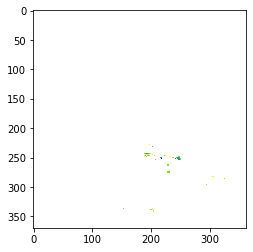

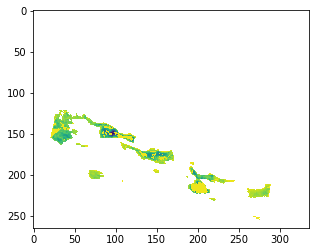

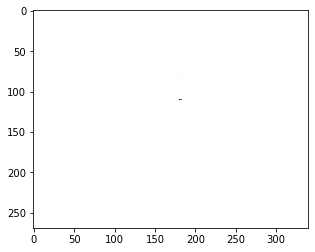

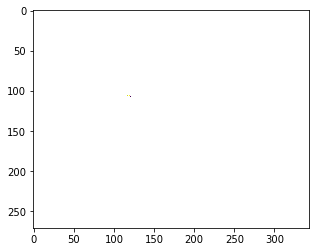

In [18]:
for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_masked = row['cum_polygon_masked_3d']
    plt.imshow(cum_masked[-1,:,:], interpolation='none')
    plt.show()

In [23]:
# Find columns (pixels) containing only zeros in the t-s and mask them

frames_gdf["cum_no_nans_zeros"] = ""
frames_gdf["non_zero_ind"] = ""
frames_gdf["non_nan_ind"] = ""

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    cum_masked = row['cum_polygon_masked_2d']

    zero_pixels = np.all(cum_masked == 0, axis=0)
    print('zero_pixels', zero_pixels.shape)
    
    # Create a new data array without columns (pixels) containing all zeros
    cum_no_zeros = cum_masked[:, ~zero_pixels]
    print('cum_no_zeros', cum_no_zeros.shape)
    
    # Print how many NaNs there are
    nan_indices = np.argwhere(np.isnan(cum_no_zeros))
    print('nan_indices', nan_indices.shape)

    # find columns containing NaNs and zeroes
    nan_pixels = np.any(np.isnan(cum_no_zeros), axis=0)
    print('nan_pixels', nan_pixels.shape)

    # create a new data array without nan columns (pixels)
    cum_no_zeros_no_nans = cum_no_zeros[:, ~nan_pixels]
    print('cum_no_zeros_no_nans', cum_no_zeros_no_nans.shape)
    # Find NaN values in cum_no_zeros
    nan_pixels = np.isnan(cum_no_zeros)

    zero_ind = np.argwhere(zero_pixels).flatten()
    non_zero_ind = np.argwhere(~zero_pixels).flatten()

    nans = np.any(np.isnan(cum_masked), axis=0)
    nan_ind = np.argwhere(nans).flatten()
    non_nan_ind = np.argwhere(~nans).flatten()

    frames_gdf.at[index, 'cum_no_nans_zeros'] = cum_no_zeros_no_nans
    frames_gdf.at[index, 'non_zero_ind'] = non_zero_ind
    frames_gdf.at[index, 'non_nan_ind'] = non_nan_ind


zero_pixels (133940,)
cum_no_zeros (192, 133897)
nan_indices (25683072, 2)
nan_pixels (133897,)
cum_no_zeros_no_nans (192, 131)
zero_pixels (89040,)
cum_no_zeros (187, 88377)
nan_indices (16023710, 2)
nan_pixels (88377,)
cum_no_zeros_no_nans (187, 2658)
zero_pixels (91460,)
cum_no_zeros (177, 91459)
nan_indices (16187712, 2)
nan_pixels (91459,)
cum_no_zeros_no_nans (177, 3)
zero_pixels (93224,)
cum_no_zeros (187, 93224)
nan_indices (17432140, 2)
nan_pixels (93224,)
cum_no_zeros_no_nans (187, 4)


In [24]:
frames_gdf["S_ft"] = ""
frames_gdf["restored_signals"] = ""
frames_gdf["restored_signals_3d"] = ""

# attempt ICA
ncomponents=4

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    data = row['cum_no_nans_zeros']
    non_nan_ind = row['non_nan_ind']
    non_zero_ind = row['non_zero_ind']
    cum = row['cum']

    # transpose data to perform temporal ica
    data_t = data.T
    print('data', data.shape)
    print('data_t', data_t.shape)

    # Check the number of features
    if data_t.shape[0] > 3 and data_t.shape[0] > ncomponents:
    # Perform ICA
        # set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
        ica = FastICA(n_components=ncomponents, whiten="unit-variance")
    
        # fit the transformer to the data array
        S_ft = ica.fit_transform(data) # fit model and recover signals
        S_t = ica.transform(data) # recover sources from x using unmixing matrix
        ## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_transform
    
        frames_gdf.at[index, 'S_ft'] = S_ft
    
        # Take each signal and restore with outer product
        restored_signals_outer = []
        three_d_list = []
        for j in range(ncomponents):
            S_j = np.copy(S_ft)
            signal = S_j[:,j]
            mixing = ica.mixing_[:,j]
            restored_signal_j = np.outer(signal, mixing)
            
            # Append the restored signal to the list
            restored_signals_outer.append(restored_signal_j)
    
            # reshape restored signal into 3d for later use
            # Convert common_indices to 3D indices i.e. flat indices into a tuple for 3d array
            # first find indices common to non nan and non zero for data population
            common_indices = np.intersect1d(non_nan_ind, non_zero_ind)
    
            # create a shape the same size as original data with nans
            cum_with_nans = np.full((cum.shape[0], cum.shape[1], cum.shape[2]), np.nan)
    
            # Convert common_indices to 3D indices i.e. flat indices into a tuple for 3d array
            indices_3d = np.unravel_index(common_indices, cum.shape[1:]) # if mask all pixels with nans
    
            # Create a copy of cum_with_nans to work with for each restored_signal
            cum_with_nans_copy = cum_with_nans.copy()
            
            # need to make sure a different time series assigned to timestep
            for m in range(restored_signal_j.shape[0]):
                # Assign values from the restored signal to non-NaN positions
                cum_with_nans_copy[m, indices_3d[0], indices_3d[1]] = restored_signal_j[m,:]
    
            # reshape cum_with_nans into time x pixels
            cum_with_nans_pix = cum_with_nans_copy.reshape(cum.shape[0], cum.shape[1] * cum.shape[2])
    
            #reshape cum_with_nans_pix into 3d to save signals
            restored_signal_3d = cum_with_nans_pix.reshape(cum.shape[0], cum.shape[1], cum.shape[2])
            three_d_list.append(restored_signal_3d)
            
        frames_gdf.at[index, 'restored_signals'] = restored_signals_outer   
        frames_gdf.at[index, 'restored_signals_3d'] = three_d_list
    else:
        print("Skipping ICA for frame {} because the number of features is not greater than 3 and/or {}.".format(frame, ncomponents))

data (192, 131)
data_t (131, 192)
data (187, 2658)
data_t (2658, 187)
data (177, 3)
data_t (3, 177)
Skipping ICA for frame 079D_05210_131313 because the number of features is not greater than 3 and/or 4.
data (187, 4)
data_t (4, 187)
Skipping ICA for frame 174A_05216_131313 because the number of features is not greater than 3 and/or 4.


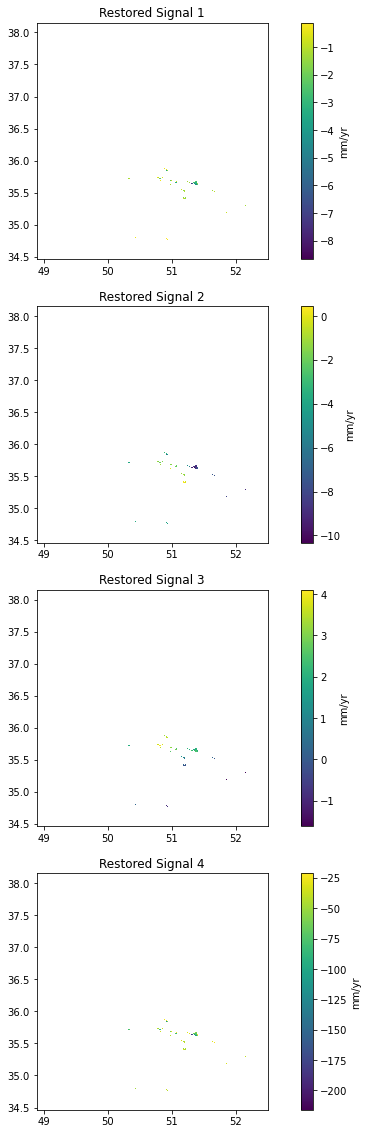

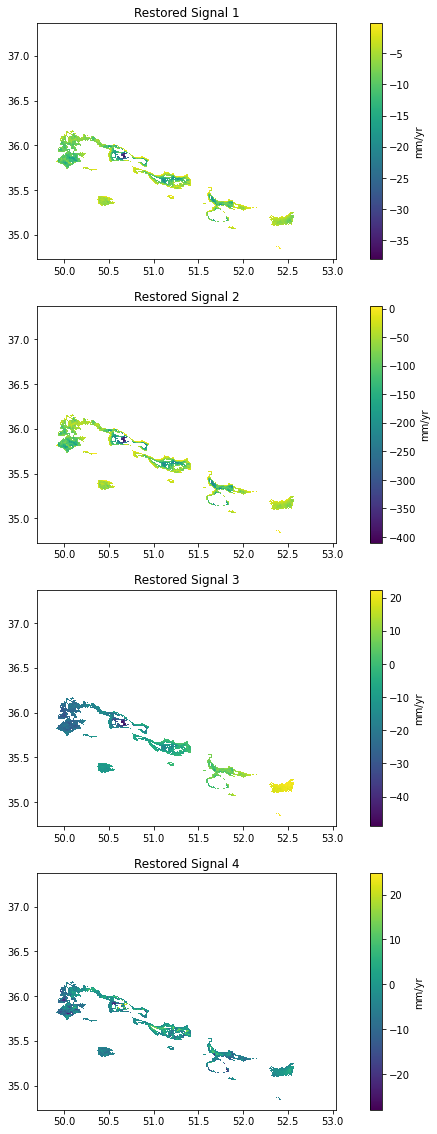

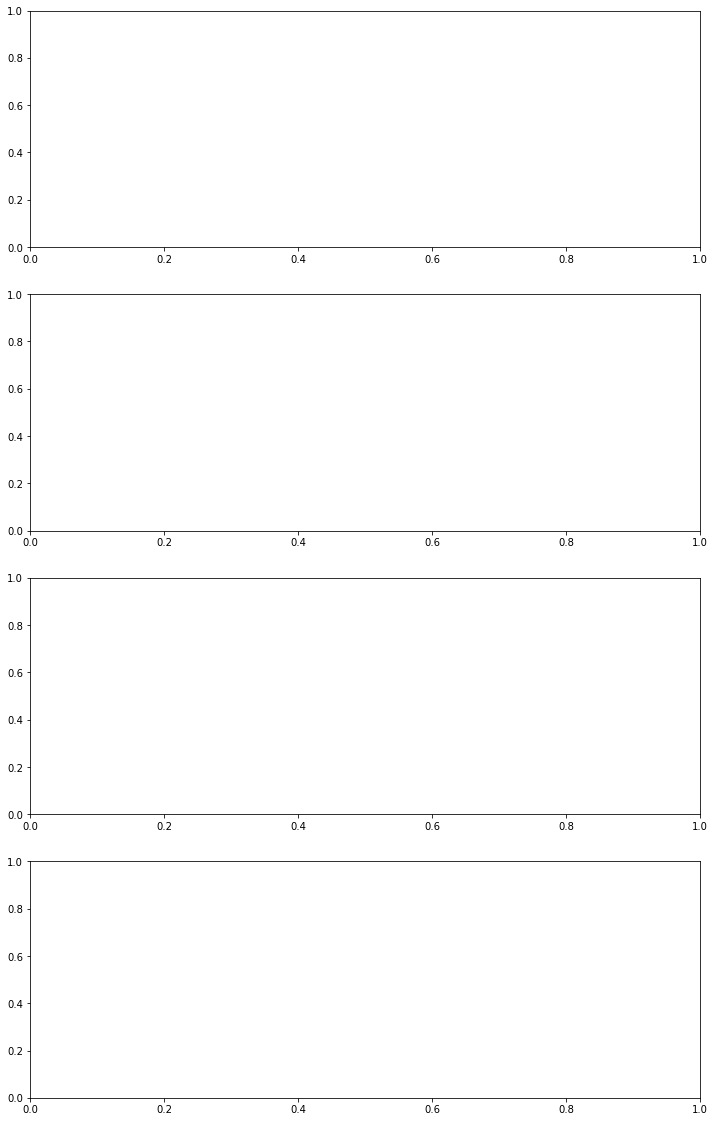

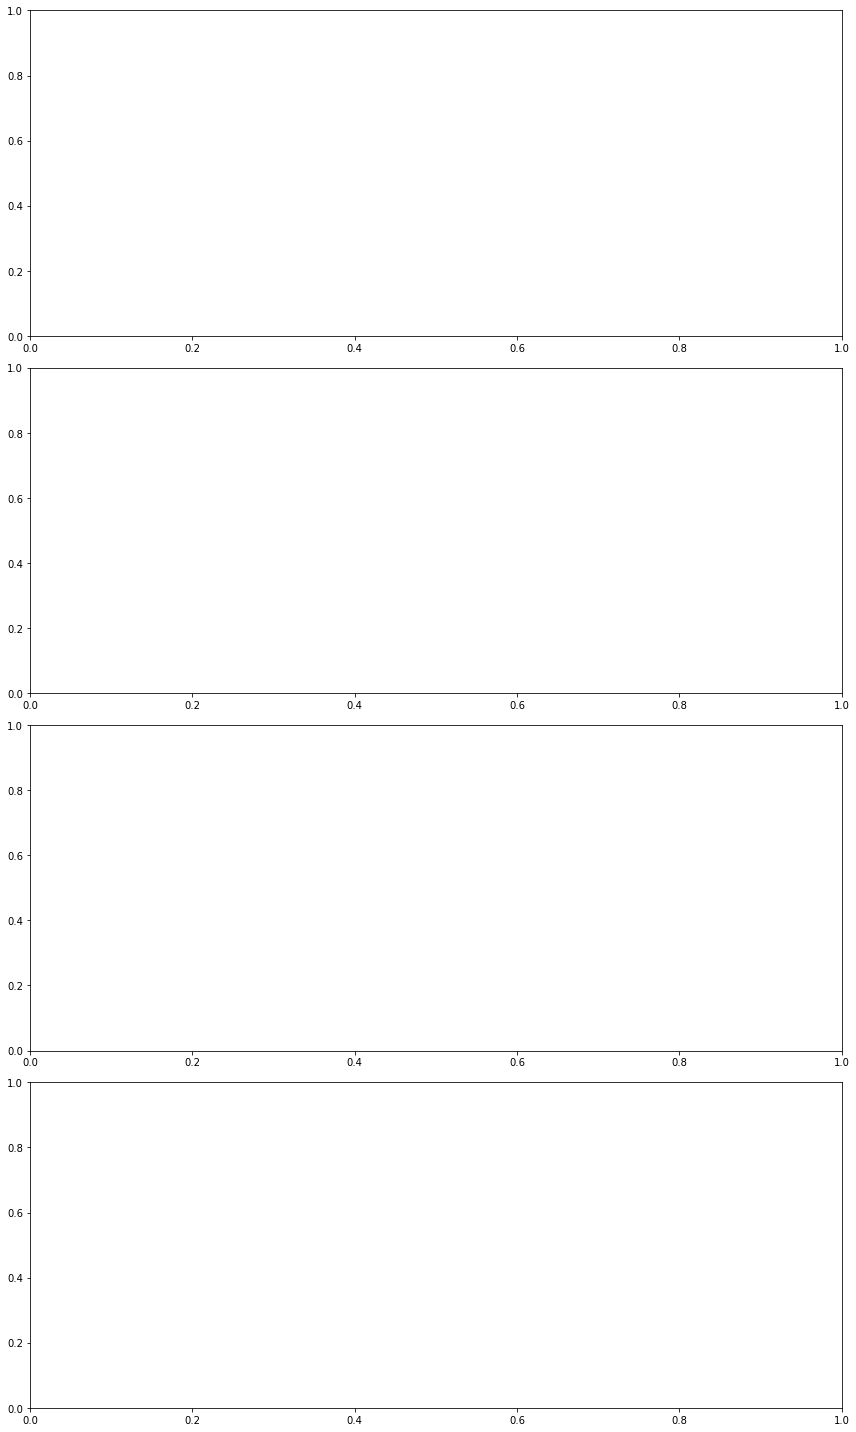

In [25]:
# Find the common indices

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    non_nan_ind = row['non_nan_ind']
    non_zero_ind = row['non_zero_ind']
    restored_signals_outer = row['restored_signals']
    cum = row['cum']
    lon_plot = row['lon']
    lat_plot = row['lat']
    common_indices = np.intersect1d(non_nan_ind, non_zero_ind)
    
    # # Create subplots
    fig, axes = plt.subplots(ncomponents, 1, figsize=(12, 20))
    # # Plot each restored signal in lat, lon on a separate subplot
    for i, (restored_signal, ax) in enumerate(zip(restored_signals_outer, axes), start=1):
        # Create a new matrix with NaNs
        cum_with_nans = np.full((cum.shape[2] * cum.shape[1],), np.nan)

         # Assign values from the restored signal to non-NaN positions
        cum_with_nans[common_indices] = restored_signal[-1] # if you mask both nan and zero pix
        cum_with_nans_reshaped = cum_with_nans.reshape((cum.shape[1], cum.shape[2]))
        lon, lat = np.meshgrid(lon_plot, lat_plot)

        # Plot on the subplot
        im = axes[i - 1].imshow(cum_with_nans_reshaped, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='viridis', interpolation ='none')
        axes[i - 1].set_title(f'Restored Signal {i}')
       # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i - 1], label='mm/yr')

plt.tight_layout()

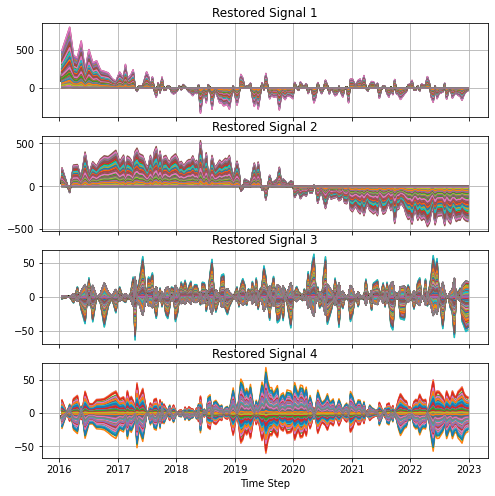

In [26]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

row_n = frames_gdf.iloc[1]

frame = row_n['frame']
restored_signals_outer = row_n['restored_signals']
dates = row_n['dates']
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    axes[i - 1].grid()
    axes[i - 1].plot(dates, restored_signal)
    axes[i - 1].set_title(f"Restored Signal {i}")

plt.xlabel('Time Step')
plt.show()

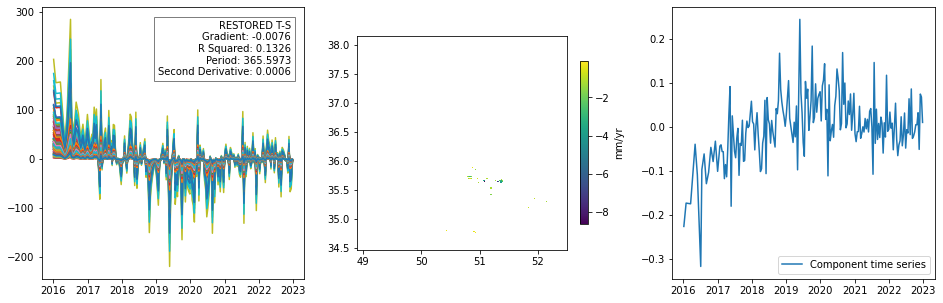

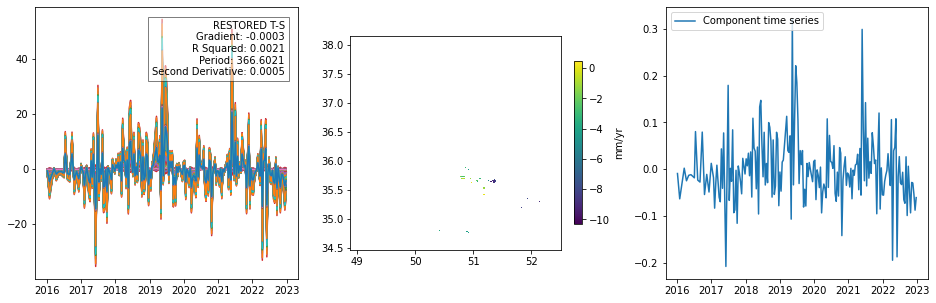

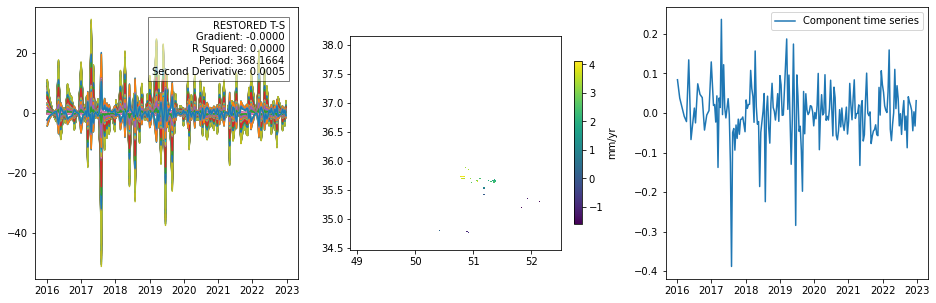

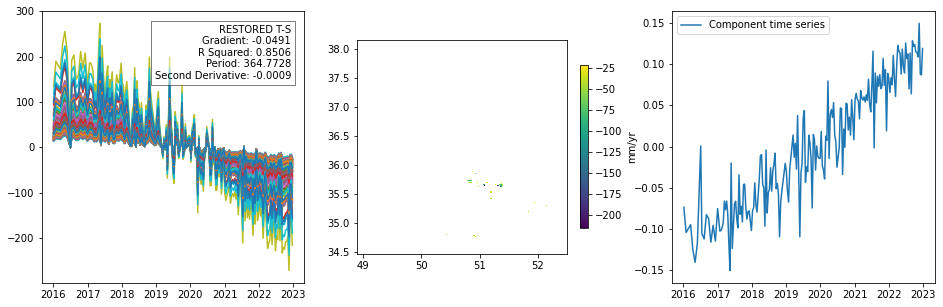

[-0.0076499025852010604, -0.0003265496859466751, -4.6276029408059276e-05, -0.04906617617261564]
[0.13256445206126682, 0.0021225843605124565, 4.6592769045303985e-05, 0.8506387805266441]
[365.5972943924725, 366.60212285864105, 368.16643173347416, 364.7727862772749]
[0.0006013146409075113, 0.0004680884227774937, 0.0005271314164117819, -0.0008685518057085825]


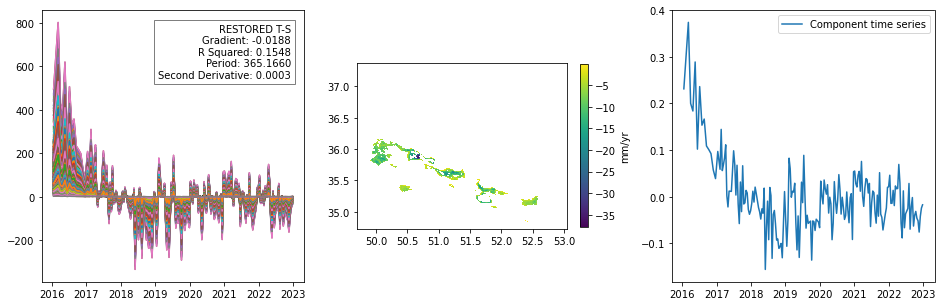

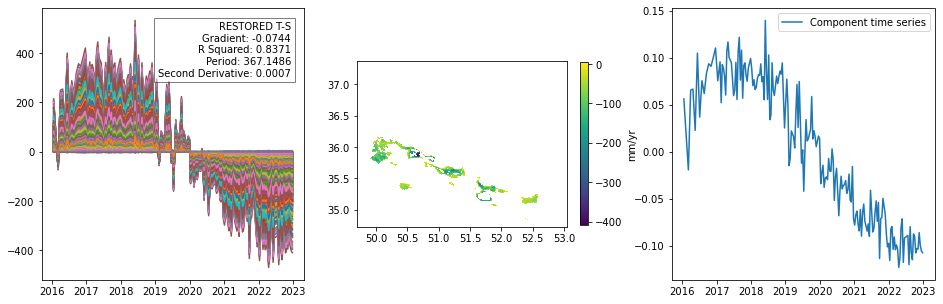

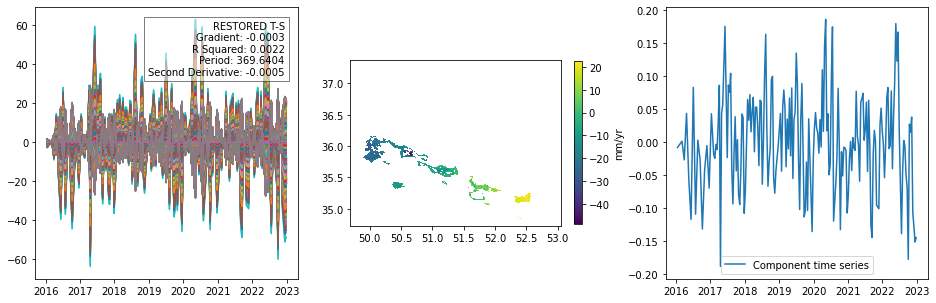

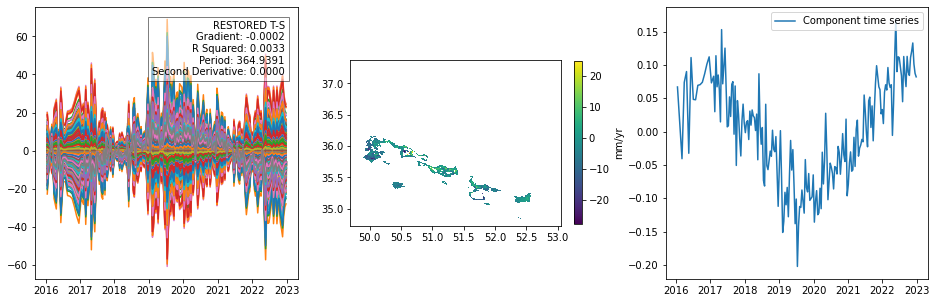

[-0.018770112042390135, -0.07444445221311166, -0.000276064720019945, -0.00020228896807639784]
[0.15484824302627043, 0.8371434270350352, 0.00221932528002025, 0.003275189539229991]
[365.1660076366647, 367.1485511510487, 369.64039714705825, 364.93910000651726]
[0.0002592989061689368, 0.0006557987361150312, -0.0004536408009160509, 3.607820019042779e-05]


In [38]:
# define function to solve for frequency and thus period of signals
def sine_function(x, f):
    return np.sin(2 * np.pi * f * x)

for index, row in frames_gdf.iterrows():
    frame = row['frame']
    dates = row['dates']
    restored_signals_3d = row['restored_signals_3d']
    restored_signals = row['restored_signals']
    corner_lat = row['corner_lat']
    corner_lon = row['corner_lon']
    post_lon = row['post_lon']
    post_lat = row['post_lat']
    width = row['width']
    height = row['length']
    lat = row['lat']
    lon = row['lon']
    nc_data = row['imdates']
    Sft = row['S_ft']

    # Only proceed if there are enough coherent pixels
    if restored_signals and restored_signals[0].shape[1] >= 20:
        # List to store R-squared values for each trend
        mean_gradient = []
        median_r_squared = []
        median_period = []
        mean_second_derivative = []

        # Convert dates to numerical values
        num_dates = date2num(dates)

        for m, signal in enumerate(restored_signals):
            r_squared_values = []
            gradient = []
            second_deriv = []
            periods = []

            # Loop through each trend at each pixel
            for i in range(signal.shape[1]):
                # Perform linear regression and calculate R-squared
                slope, _, r_value, _, _ = linregress(num_dates, signal[:, i])

                # Store the gradient at each pixel
                gradient.append(slope)

                # Append R-squared value to the list
                r_squared_values.append(r_value ** 2)

                # Calculate the second derivative using numpy.gradient at each pixel
                first_derivative = np.gradient(signal[:, i], num_dates)
                second_derivative = np.gradient(first_derivative, num_dates)
                second_derivative_mean = np.mean(second_derivative)
                second_deriv.append(second_derivative_mean)

                try:
                    # fit signal with sine function
                    popt, pcov = curve_fit(sine_function, num_dates, signal[:, i], p0=((1/365.25)), maxfev=1000)
                    optimal_frequency = popt[0]
                    period = 1 / optimal_frequency
                    periods.append(period)
                except (RuntimeError, OptimizeWarning) as e:
                    print(f"Curve fitting did not converge for signal {i}. Skipping...")
                    periods.append(None)
                    
            # take mean of gradients
            mean_gradient.append(np.mean(gradient))
            # take median of r_squared per IC
            median_r_squared.append(np.median(r_squared_values))
            # find median period of signal
            median_period.append(np.median(period))
            # take mean of second derivative per IC
            mean_second_derivative.append(np.mean(second_deriv))

            # plot components in space and time with parameters
            plt.figure(figsize=(16,5))
            plt.subplot2grid((1, 3), (0, 0))
            plt.plot(dates,signal)
            # Adding text to the top right of the plot
            plt.text(0.95, 0.95, f"RESTORED T-S\nGradient: {np.mean(gradient):.4f}\nR Squared: {np.median(r_squared_values):.4f}\nPeriod: {np.median(period):.4f}\nSecond Derivative: {np.mean(second_deriv):.4f}",
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.5))

            plt.subplot2grid((1, 3), (0, 1))
            plt.imshow(restored_signals_3d[m][-1,:,:], cmap='viridis', interpolation='none', extent=[np.amin(lon), np.amax(lon), np.amin(lat), np.amax(lat)])
            cbar = plt.colorbar(label='mm/yr', shrink=0.6)

            plt.subplot2grid((1, 3), (0, 2))
            plt.plot(dates,Sft[:,m], label = 'Component time series')
            plt.legend()
            plt.show()
            

        # If mean gradient is negative, find the index of the trend with the maximum R-squared value
        negative_indices = [i for i, val in enumerate(mean_gradient) if val < 0]
        if negative_indices:
            median_r_squared_negative_gradients = [median_r_squared[i] for i in negative_indices]
            max_r_squared_negative_grad = np.max(median_r_squared_negative_gradients)
            max_index_in_median_r_squared = median_r_squared.index(max_r_squared_negative_grad)

            # Choose the signal
            inelastic_signal = restored_signals_3d[max_index_in_median_r_squared]
            inelastic_signal_subsiding = restored_signals[max_index_in_median_r_squared]
            print(mean_gradient)
            print(median_r_squared)
            print(median_period)
            print(mean_second_derivative)

            # Save as NetCDF
            output_nc_dir = f"/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/inelastic_components/{ncomponents}_comp/"
            if not os.path.exists(output_nc_dir):
                os.makedirs(output_nc_dir)

            output_nc_path = os.path.join(output_nc_dir, f"{frame}_inelastic_component_{ncomponents}.nc")

            with nc.Dataset(output_nc_path, 'w') as file:
                # Create dimensions
                file.createDimension('dates', inelastic_signal.shape[0])
                file.createDimension('latitude', inelastic_signal.shape[1])
                file.createDimension('longitude', inelastic_signal.shape[2])

                # Create variables
                time_var = file.createVariable('dates', 'f4', ('dates',))
                lat_var = file.createVariable('latitude', 'f4', ('latitude',))
                lon_var = file.createVariable('longitude', 'f4', ('longitude',))
                data_var = file.createVariable('data', 'f4', ('dates', 'latitude', 'longitude'))
                period_var = file.createVariable('period', 'f4')
                second_derivative_var = file.createVariable('second_derivative', 'f4')

                # Add data to variables
                time_var[:] = nc_data
                lat_var[:] = lat
                lon_var[:] = lon
                data_var[:] = inelastic_signal
                period_var[:] = median_period[max_index_in_median_r_squared]
                second_derivative_var[:] = mean_second_derivative[max_index_in_median_r_squared]

            # Save as GeoTIFF
            output_tif_dir = f"/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/inelastic_components/{ncomponents}_comp/"
            if not os.path.exists(output_tif_dir):
                os.makedirs(output_tif_dir)
 
            output_tif_path = os.path.join(output_tif_dir, f"{frame}_inelastic_component_{ncomponents}.tif")
            # Create a transformation for the GeoTIFF
            post_lat_pos = post_lat*(-1)
            transform = from_origin(corner_lon, corner_lat, post_lon, post_lat_pos)

            with rasterio.open(output_tif_path, 'w', driver='GTiff', height=height, width=width, count=1,
                               dtype='float32', crs='EPSG:4326', transform=transform) as dst:
                # Write the data to the GeoTIFF
                dst.write(inelastic_signal[-1, :, :], 1)

        # Save other signals as NetCDF
        output_nc_dir = f"/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/other_components/{ncomponents}_comp/{frame}"
        if not os.path.exists(output_nc_dir):
            os.makedirs(output_nc_dir)

        output_nc_path = os.path.join(output_nc_dir, f"other_component.nc")

        with nc.Dataset(output_nc_path, 'w') as file:
            # Create dimensions
            file.createDimension('dates', inelastic_signal.shape[0])
            file.createDimension('latitude', inelastic_signal.shape[1])
            file.createDimension('longitude', inelastic_signal.shape[2])

            # Create variables
            time_var = file.createVariable('dates', 'f4', ('dates',))
            lat_var = file.createVariable('latitude', 'f4', ('latitude'))
            lon_var = file.createVariable('longitude', 'f4', ('longitude'))
            
            # Create variables for each component
            data_vars = []
            period_vars = []
            second_derivative_vars = []

            for comp_index in range(ncomponents - 1):
                data_var = file.createVariable(f'data_{comp_index}', 'f4', ('dates', 'latitude', 'longitude'))
                period_var = file.createVariable(f'period_{comp_index}', 'f4')
                second_derivative_var = file.createVariable(f'second_derivative_{comp_index}', 'f4')
    
                data_vars.append(data_var)
                period_vars.append(period_var)
                second_derivative_vars.append(second_derivative_var)

            # Add data, period, and second derivative to variables
            comp_index=0
            for i, signal_3d in enumerate(restored_signals_3d):
                if i != max_index_in_median_r_squared:
                    data_vars[comp_index][:] = signal_3d
                    period_vars[comp_index][:] = median_period[i]
                    second_derivative_vars[comp_index][:] = mean_second_derivative[i]
                    comp_index += 1

            time_var[:] = nc_data
            lat_var[:] = lat
            lon_var[:] = lon

            # Save as GeoTIFF
            output_tif_dir = f"/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/all_iran/other_components/{ncomponents}_comp/{frame}"

            # Check if the directory exists
            if os.path.exists(output_tif_dir):
                # Iterate over the files in the directory
                for filename in os.listdir(output_tif_dir):
                # Check if the file is a GeoTIFF
                    if filename.endswith(".tif"):
                        # Construct the full path to the file
                        file_path = os.path.join(output_tif_dir, filename)
                        # Delete the file
                        os.remove(file_path)
            else:
                print("Directory does not exist.")
                
            for i, signal_3d in enumerate(restored_signals_3d):
                if i != max_index_in_median_r_squared:
                    output_tif_path = os.path.join(output_tif_dir, f"other_component_{i}.tif")
                    with rasterio.open(output_tif_path, 'w', driver='GTiff', height=height, width=width, count=1,
                                       dtype='float32', crs='EPSG:4326', transform=transform) as dst:
                        # Write the data to the GeoTIFF
                        dst.write(signal_3d[-1, :, :], 1)